<font size=7>QDA, LR, SVM for Fraud Detection</font>

**关键词：** **Classification**，*Binary Classification*，**imblearn**，**ClusterCentroids**， **RFE(recursive feature elimination)**，**Finance**，**Logistic Regression**，**QDA**，*SVM*

This kernel is using QDA (Quadratic Discriminant Analysis), LR (Logistic Regression), and SVM (Support Vector Machine) models to help detect Fraud Credit Card transactions.

With the provided dataset, we have 492 frauds out of 284,807 transactions, or the positive class (frauds) account for 0.172% of all transactions. In addition, we have a high dimentional dataset with 30 features, including 28 PCA-ed features (V1, V2, ... V28), 'Amount', and 'Time' features.

Due to the highly unbalanced dataset, we will apply Sampling technique to under-sample the majority class, and over-sample the minority class before training process.

Also, we used recursive feature elimination and cross-validated technique for features selection.

In this exercise, we will focus on the Recall score of the model - Fraud detection (True Negative Classification); however, we also consider the trade-off on the Precision score - Normal transaction classification rate (True Positive Classification).

导入依赖包：

In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn import discriminant_analysis
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.datasets import make_classification

import itertools
from itertools import cycle

import random

定义常量：

In [15]:
random_state = 42
random.seed(random_state)
np.random.seed(random_state)

cv_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
scoring_acc = make_scorer(accuracy_score, greater_is_better=True, needs_proba=False)

# 数据探索

读取数据：

In [16]:
df = pd.read_csv('.\data\creditcard.csv')

In [17]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [18]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

热力图观察是否有空值：

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


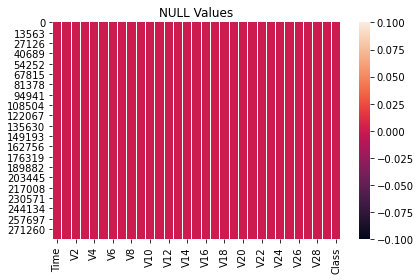

In [20]:
# NULL Analysis
print(df.isnull().sum())

sns.heatmap(df.isnull(), cbar=True)
plt.title('NULL Values')
plt.tight_layout() # Adjust the padding between and around subplots.

数据集没有空值。

观察不同类别样本数量是否平衡：

Class : 0, Count : 284315
Class : 1, Count : 492


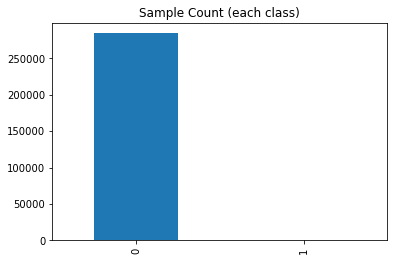

In [21]:
target_counts = df['Class'].value_counts()

# unique, counts = np.unique(y_train, return_counts=True)
# target_counts = dict(zip(unique, counts))

for key, val in target_counts.items():
    #print(f"Class : {label_decoder[key]}, Count : {val}")
    print(f"Class : {key}, Count : {val}")

fig, ax = plt.subplots()
fig.canvas.draw()
#pd.Series(target_counts).plot(kind='bar', title='Sample Count (each class)')
target_counts.plot(kind='bar', title='Sample Count (each class)')
code_labels = [item.get_text() for item in ax.get_xticklabels()]
#text_labels = [label_decoder[int(float(item))] for item in code_labels]
text_labels = [int(float(item)) for item in code_labels]
ax.set_xticklabels(text_labels, rotation=90)
plt.show()

# 特征选择

In [22]:
y_target = df.Class
X_data = df.drop(['Class'], axis=1)

Feature ranking with recursive feature elimination(RFE) and cross-validated selection of the best number of features.

In [32]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()

# determinant algorithm to select features
rfecv = RFECV(estimator=lda, step=1, cv=cv_skf, scoring=scoring_acc)
rfecv.fit(X_data, y_target)

selected_features = X_data.columns[rfecv.support_]
print('Optimal number of features :', rfecv.n_features_)
print('Selected best features :', selected_features)
print('Original features :', X_data.columns)

Optimal number of features : 10
Selected best features : Index(['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'], dtype='object')
Original features : Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


选择和特征数量与交叉验证的成绩：

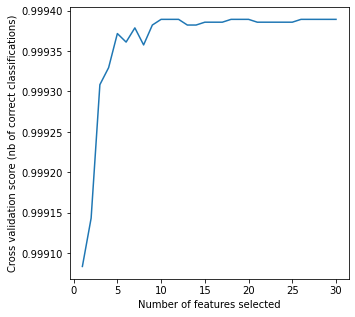

In [33]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# 数据集划分

In [34]:
dfFraud = df[df.Class==1]
dfNorm = df[df.Class==0]
ratio = float(len(dfFraud))/len(dfNorm)

In [ ]:
#Shuffle the dataframes so that the training is done in a random order.
dfNorm = shuffle(dfNorm)
dfFraud = shuffle(dfFraud)

# Set X_train equal to 80% of the fraudulent transactions.
X_train = dfFraud.sample(frac=0.8)

# Add 80% of the normal transactions to X_train.
X_train = pd.concat([X_train, dfNorm.sample(frac = 0.8)], axis = 0)

# X_test contains all the transaction not in X_train.
X_test = df.loc[~df.index.isin(X_train.index)]

y_train = X_train['Class']
y_test = X_test['Class']

特征选择后的训练集与测试集：

In [38]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# 欠/过采样以平衡样本集

## 样本欠采样

In [39]:
from imblearn.under_sampling import ClusterCentroids


cc = ClusterCentroids(random_state=random_state)
X_resampled, y_resampled = cc.fit_sample(X_train, y_train)

欠采样后的训练集：

In [40]:
X_train_ = X_resampled
y_train_ = y_resampled
X_test_ = X_test
y_test_ = y_test

观察是否已经平衡：

Class : 0, Count : 394
Class : 1, Count : 394


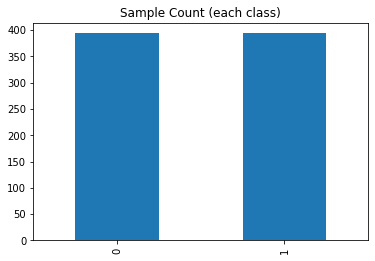

In [41]:
unique, counts = np.unique(y_train_, return_counts=True)
target_counts = dict(zip(unique, counts))

for key, val in target_counts.items():
    #print(f"Class : {label_decoder[key]}, Count : {val}")
    print(f"Class : {key}, Count : {val}")

fig, ax = plt.subplots()
fig.canvas.draw()
pd.Series(target_counts).plot(kind='bar', title='Sample Count (each class)')
code_labels = [item.get_text() for item in ax.get_xticklabels()]
#text_labels = [label_decoder[int(float(item))] for item in code_labels]
text_labels = [int(float(item)) for item in code_labels]
ax.set_xticklabels(text_labels, rotation=90)
plt.show()

## 训练集欠采样前后样本对比

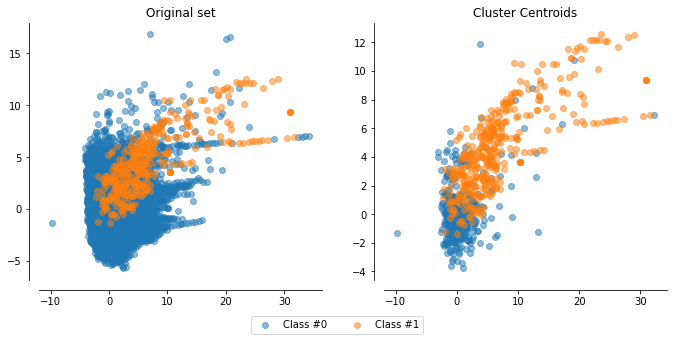

In [42]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X_train)

# Apply SMOTE + ENN
#sm = SMOTEENN(ratio = 'minority')
#X_resampled, y_resampled = sm.fit_sample(X_train, y_train)
X_res_vis = pca.transform(X_resampled)

# Two subplots, unpack the axes array immediately
plt.rcParams['figure.figsize'] = 10, 5
f, (ax1, ax2) = plt.subplots(1, 2)

c0 = ax1.scatter(X_vis[y_train == 0, 0], X_vis[y_train == 0, 1], label="Class #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y_train == 1, 0], X_vis[y_train == 1, 1], label="Class #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_resampled == 0, 0], X_res_vis[y_resampled == 0, 1],
            label="Class #0", alpha=0.5)
ax2.scatter(X_res_vis[y_resampled == 1, 0], X_res_vis[y_resampled == 1, 1],
            label="Class #1", alpha=0.5)
#ax2.set_title('SMOTE + ENN')
ax2.set_title('Cluster Centroids')

# make nice plotting
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    #ax.set_xlim([-6, 8])
    #ax.set_ylim([-6, 6])

f.legend((c0, c1), ('Class #0', 'Class #1'), loc='lower center',
         ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()

# 模型训练

## QDA

### QDA模型训练

In [43]:
QDA_model = discriminant_analysis.QuadraticDiscriminantAnalysis()
QDA_model.fit(X_train_, y_train_)

QuadraticDiscriminantAnalysis()

In [44]:
QDA_model.score(X_train_, y_train_)

0.9022842639593909

Confusion matrix, without normalization
[[369  25]
 [ 52 342]]
Normalized confusion matrix
[[0.94 0.06]
 [0.13 0.87]]


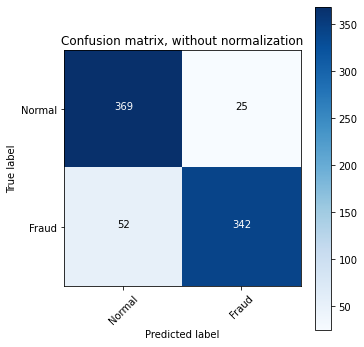

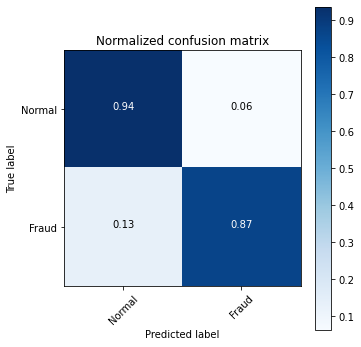

In [45]:
class_names = ["Normal", "Fraud"]


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plotConfusion(model, X, y):
    y_true, y_pred = y, model.predict(X)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

plotConfusion(QDA_model, X_train_, y_train_)

测试集成绩：

In [46]:
QDA_model.score(X_test_, y_test_)

0.9826723547690525

Confusion matrix, without normalization
[[55889   974]
 [   13    85]]
Normalized confusion matrix
[[0.98 0.02]
 [0.13 0.87]]


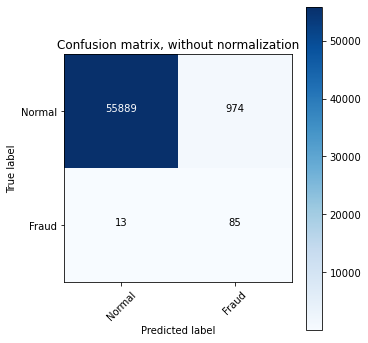

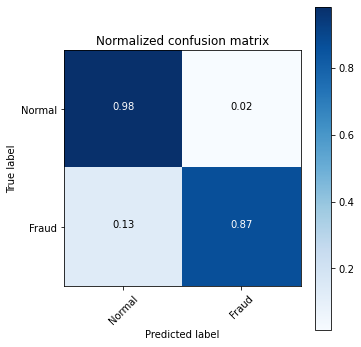

In [47]:
plotConfusion(QDA_model, X_test_, y_test_)

### QDA模型分类过程

In [48]:
def plotModel(model, x, y, label):
    '''
    model: a fitted model
    x, y: two variables, should arrays
    label: true label
    '''
    x_min = x.min() - 1
    x_max = x.max() + 1
    y_min = y.min() - 1
    y_max = y.max() + 1
    import matplotlib.pyplot as pl
    from matplotlib import colors
    colDict = {'red': [(0, 1, 1), (1, 0.7, 0.7)],
               'green': [(0, 1, 0.5), (1, 0.7, 0.7)],
               'blue': [(0, 1, 0.5), (1, 1, 1)]}
    cmap = colors.LinearSegmentedColormap('red_blue_classes', colDict)
    plt.cm.register_cmap(cmap=cmap)
    nx, ny = 200, 200
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ## plot colormap
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes')
    ## plot boundaries
    plt.contour(xx, yy, Z, [0.5], linewidths=1., colors='k')
    plt.contour(xx, yy, Z, [1], linewidths=1., colors='k')
    ## plot scatters ans true labels
    plt.scatter(x, y, c = label)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

labels = X_train.columns.values

def pairPlot(model, i, j):
    model.fit(X_test_.iloc[:,[i,j]], y_test_)
    plotModel(model, X_test_.iloc[:, i], X_test_.iloc[:, j], y_test_)
    plt.xlabel(labels[i])
    plt.ylabel(labels[j])

C:\Users\anrui\AppData\Local\Temp\ipykernel_10884\3380115303.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes')
C:\Users\anrui\AppData\Local\Temp\ipykernel_10884\3380115303.py:27: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z, [1], linewidths=1., colors='k')
C:\Users\anrui\AppData\Local\Temp\ipykernel_10884\3380115303.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases la

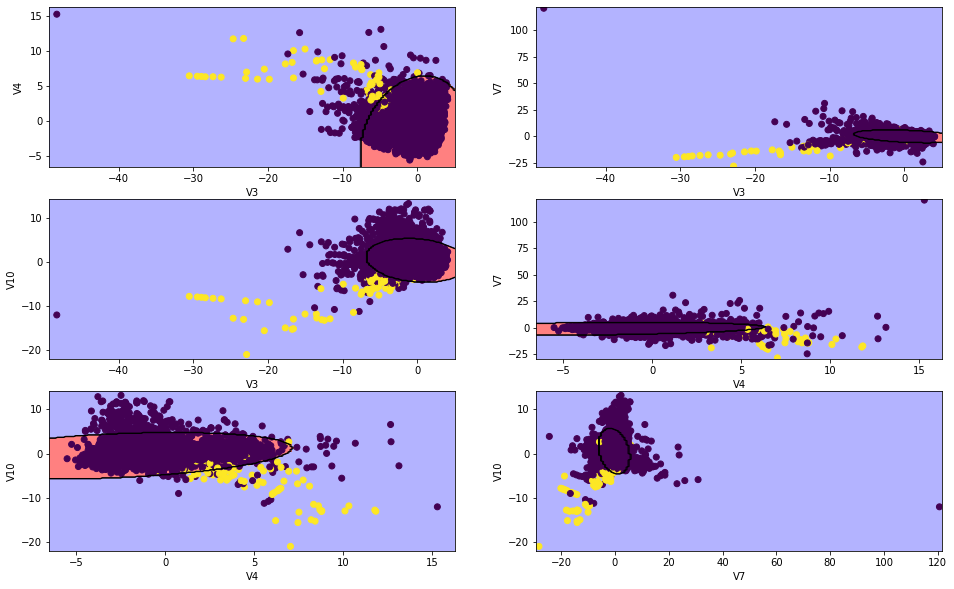

In [49]:
plt.rcParams['figure.figsize'] = 16, 10
plt.subplot(321)
pairPlot(QDA_model, 0, 1)

plt.subplot(322)
pairPlot(QDA_model, 0, 2)

plt.subplot(323)
pairPlot(QDA_model, 0, 3)

plt.subplot(324)
pairPlot(QDA_model, 1, 2)

plt.subplot(325)
pairPlot(QDA_model, 1, 3)

plt.subplot(326)
pairPlot(QDA_model, 2, 3)

## Logistic Regression

### LR模型训练

In [50]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)

clf.fit(X_train_, y_train_)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [51]:
clf.best_params_

{'C': 1}

### LR模型表现

Confusion matrix, without normalization
[[380  14]
 [ 48 346]]
Normalized confusion matrix
[[0.96 0.04]
 [0.12 0.88]]


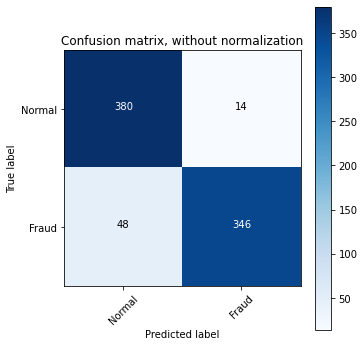

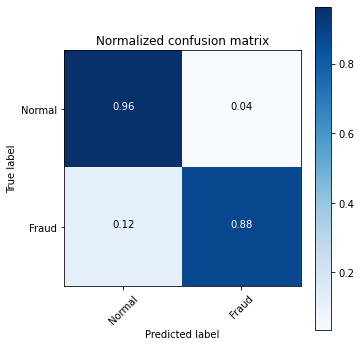

In [52]:
plotConfusion(clf, X_train_, y_train_)

测试集成绩：

Confusion matrix, without normalization
[[56318   545]
 [   13    85]]
Normalized confusion matrix
[[0.99 0.01]
 [0.13 0.87]]


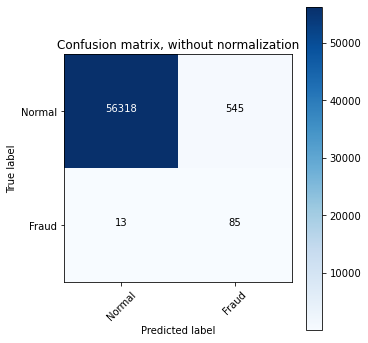

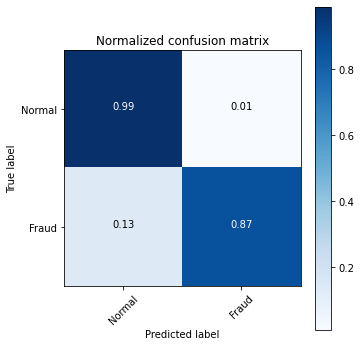

In [53]:
plotConfusion(clf, X_test_, y_test_)

### LR模型概率阈值

Probability Threshold: 0.00
Recall metric: 1.00
Precision metric: 0.00
Probability Threshold: 0.10
Recall metric: 1.00
Precision metric: 0.52
Probability Threshold: 0.20
Recall metric: 0.96
Precision metric: 0.87
Probability Threshold: 0.30
Recall metric: 0.94
Precision metric: 0.95
Probability Threshold: 0.40
Recall metric: 0.88
Precision metric: 0.98
Probability Threshold: 0.50
Recall metric: 0.87
Precision metric: 0.99
Probability Threshold: 0.60
Recall metric: 0.86
Precision metric: 0.99
Probability Threshold: 0.70
Recall metric: 0.85
Precision metric: 1.00
Probability Threshold: 0.80
Recall metric: 0.83
Precision metric: 1.00
Probability Threshold: 0.90
Recall metric: 0.72
Precision metric: 1.00


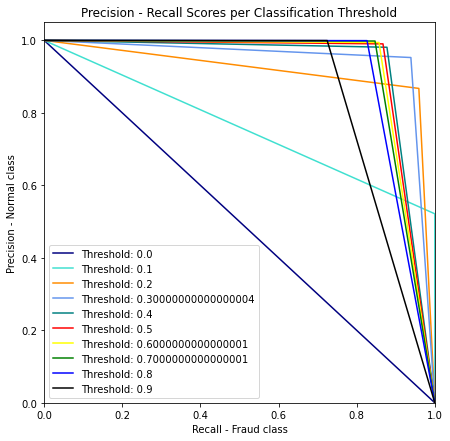

In [56]:
y_pred_test_proba = clf.predict_proba(X_test_)

thresholds = np.arange(0.0, 1, 0.1)
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

prec, rec = [],[]
for i in thresholds:
    y_test_predictions_high_recall = y_pred_test_proba[:,1] > i # 第一列概率值最大
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test_,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    
    p = float(cnf_matrix[0,0])/(cnf_matrix[0,1]+cnf_matrix[0,0])
    r = float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1])
    rec.append(r)
    prec.append(p)

    print("Probability Threshold: {0:0.2f}".format(i))
    print("Recall metric: {0:0.2f}".format(r))
    print("Precision metric: {0:0.2f}".format(p))

plt.figure(figsize=(7,7))

for i,color,r,p in zip(thresholds,colors,rec,prec):
    plt.plot([0, r, 1], [1, p, 0],color=color, label='Threshold: %s'%i)
    plt.ylabel('Precision - Normal class')
    plt.xlabel('Recall - Fraud class')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision - Recall Scores per Classification Threshold')
    plt.legend(loc="lower left")

选择最佳阈值，使得召回率和精确率都很高。

## SVM

### SVM模型训练

In [57]:
tuned_parameters = [{'kernel': ['rbf','poly'], 'gamma': [1e-3,  1e-4], 'C': [1,10,100,1000]}]
scores = ['precision', 'recall']

In [58]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    svm = GridSearchCV(SVC(), tuned_parameters, cv=5,scoring='%s_macro' % score)
    svm.fit(X_train_, y_train_)

    print("Best parameters set found on Training dataset:")
    print()
    print(svm.best_params_)
    print()
    print("Grid scores on Training dataset:")
    print()
    means = svm.cv_results_['mean_test_score']
    stds = svm.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, svm.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    y_true_test_svm, y_pred_test_svm = y_test_, svm.predict(X_test_)
    print(classification_report(y_true_test_svm, y_pred_test_svm))
    print()

# Tuning hyper-parameters for precision



d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters set found on Training dataset:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on Training dataset:

0.925 (+/-0.025) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.820 (+/-0.019) for {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
0.908 (+/-0.024) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.555 (+/-0.501) for {'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}
0.921 (+/-0.020) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.850 (+/-0.020) for {'C': 10, 'gamma': 0.001, 'kernel': 'poly'}
0.922 (+/-0.032) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.763 (+/-0.041) for {'C': 10, 'gamma': 0.0001, 'kernel': 'poly'}
0.927 (+/-0.022) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.881 (+/-0.037) for {'C': 100, 'gamma': 0.001, 'kernel': 'poly'}
0.920 (+/-0.020) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.777 (+/-0.028) for {'C': 100, 'gamma': 0.0001, 'kernel': 'poly'}
0.923 (+/-0.019) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.893 (+/-0.027) for {'C': 

Confusion matrix, without normalization
[[56535   328]
 [   15    83]]
Normalized confusion matrix
[[0.99 0.01]
 [0.15 0.85]]


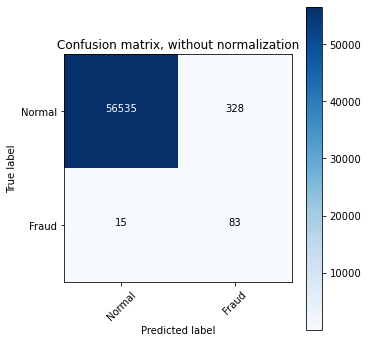

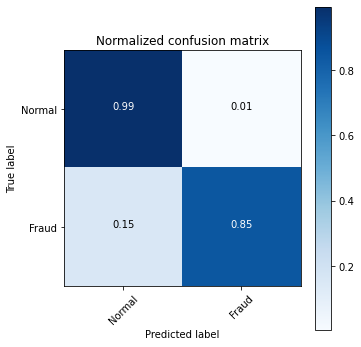

In [59]:
plotConfusion(svm, X_test_, y_test_)